In [49]:
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
import scipy.optimize as opt
import seaborn as sns
import os

# GHG Hub folders for Summer School Exercises
OBSPACK_FOLDER = os.path.join(os.environ['HOME'], 'shared/ssim-ghg-data/obspacks/obspack_co2_1_GLOBALVIEWplus_v9.1_2023-12-08/data/nc')
FLUX_FOLDER = os.path.join(os.environ['HOME'], 'shared/ssim-ghg-data/ameriflux')

# Sean's local folders for testing
#OBSPACK_FOLDER = os.path.join(os.environ['HOME'], 'Google Drive/My Drive/csu_summer_school/obspack_co2_1_GLOBALVIEWplus_v9.1_2023-12-08/data/nc')
#FLUX_FOLDER = os.path.join(os.environ['HOME'],'Google Drive/My Drive/csu_summer_school/')


# Analysis of LEF data at 3 different levels
## Read in LEF data at all levels and create afternoon averages for each day


In [24]:
files = glob(os.path.join(OBSPACK_FOLDER, 'co2_lef_tower-insitu_1_allvalid*.nc'))
lef_all = {}
lef_day = {}
for fi in files:
    ht = int(fi.split('-')[-1].split('.nc')[0].split('magl')[0])
    tmp = xr.open_dataset(fi)
    lef_all[ht] = pd.DataFrame({'co2':tmp['value'].data*1e6,'lat':tmp['latitude'].data,'lon':tmp['longitude']},index=tmp['time'].data)
    solar_time = np.array([lef_all[ht].index[i] + dt.timedelta(hours=lef_all[ht]['lon'].iloc[i]/180. * 12) for i in range(len(lef_all[ht].index))])
    lef_all[ht].index = solar_time[:]

for ht in lef_all.keys():
    lef_day[ht] = lef_all[ht].between_time('12:00','16:00').groupby(pd.Grouper(freq='D')).mean()
    lef_day[ht].dropna()

## Plot full and afternoon averaged time series to see impacts of filtering

Text(0, 0.5, 'CO$_2$ Dry Air Mole Fraction (ppm)')

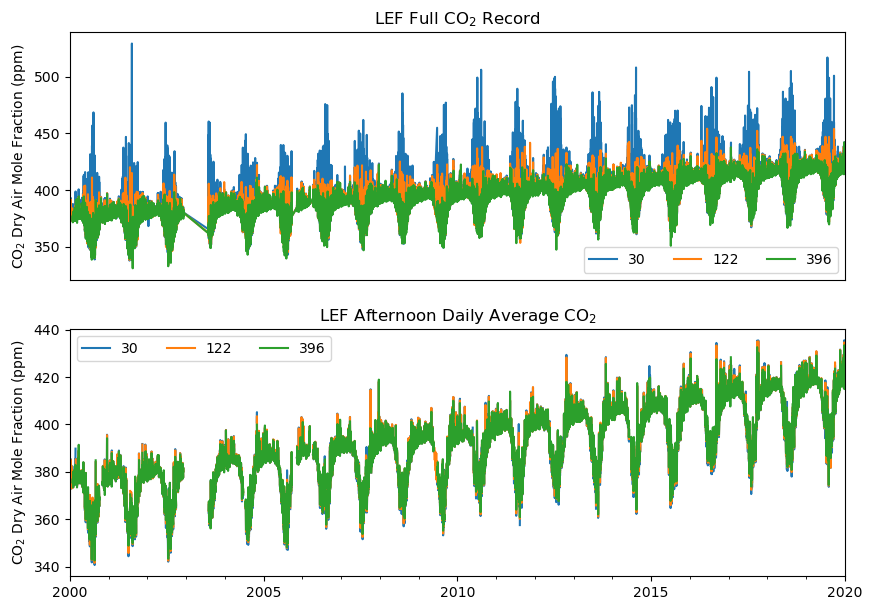

In [26]:
fig,axs = plt.subplots(2,1,figsize=(10,8))
heights = [30,122,396]
for ky in heights:
  lef_all[ky][dt.datetime(2000,1,1):dt.datetime(2020,1,1)].co2.plot(title='LEF Full CO$_2$ Record',ax=axs[0])
  lef_day[ky][dt.datetime(2000,1,1):dt.datetime(2020,1,1)].co2.plot(title='LEF Afternoon Daily Average CO$_2$',ax=axs[1])
axs[0].legend(heights,ncol=3)
axs[0].set_ylabel(r'CO$_2$ Dry Air Mole Fraction (ppm)')
axs[0].set_xticks([])
xl = axs[1].get_xlim()
axs[0].set_xlim(xl)
axs[1].legend(heights,ncol=3)
axs[1].set_ylabel(r'CO$_2$ Dry Air Mole Fraction (ppm)')

#### Zoom in on a few recent years

As long as you have a DateTime index for your DataFrame, you can subsample with the DateTime objects directly

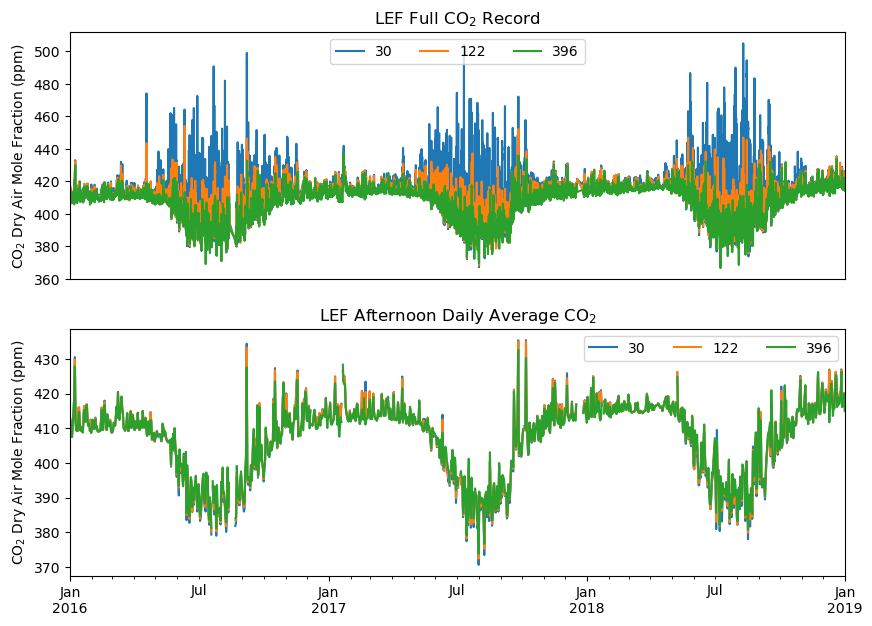

In [27]:
fig,axs = plt.subplots(2,1,figsize=(10,8))
heights = [30,122,396]
for ky in heights:
  #Syntax is df[datetime1:datetime2] to subsample a DataFrame
  lef_all[ky][dt.datetime(2016,1,1):dt.datetime(2019,1,1)].co2.plot(title='LEF Full CO$_2$ Record',ax=axs[0])
  lef_day[ky][dt.datetime(2016,1,1):dt.datetime(2019,1,1)].co2.plot(title='LEF Afternoon Daily Average CO$_2$',ax=axs[1])
axs[0].legend(heights,ncol=3)
axs[0].set_ylabel(r'CO$_2$ Dry Air Mole Fraction (ppm)');
axs[0].set_xticks([])
xl = axs[1].get_xlim()
axs[0].set_xlim(xl)
axs[1].legend(heights,ncol=3)
axs[1].set_ylabel(r'CO$_2$ Dry Air Mole Fraction (ppm)');

## Questions
1. What happened to the "spikes" in the full data record when we only look at the daytime average data?
2. Why do the time series look so different?

## Fit a trend and seasonal cycle to the daytime data
### We treat the trend with a polynomial and the seasonality as a pure sinusoid or a skewed sinusoid:

Thoning fit: $f(t) = a_o + a_1 t + ... + a_n t^n + \Sigma_{i=1}^{nh} c_i \sin(2\pi i t + \phi_i)$

Skew Sine Wave: $f(t) = a_o + + a_1 t + ... + a_n t^n + c_o \sin[\omega (t-\phi_1) + \cos^{-1}(c_1\cos(\omega(t-\phi_2)))]$

In [28]:
def thoning(x,*params):
  fout = 0.
  pn = params[:4]
  for ip,p in enumerate(pn):
    fout += p*x**ip
  cn = params[4:]
  nh = len(cn)//2
  for i in range(nh):
    fout += cn[i]*np.sin(2*np.pi*(i+1)*x + cn[i+nh])
  return fout

def skewsine(x,*params):
    fout = 0.
    pn = params[:4]
    for ip,p in enumerate(pn):
        fout += p*x**ip
    cn = params[4:]
    freq = 2*np.pi/365.
    fout += cn[0]*np.sin(freq*(x-cn[1])+np.arccos(cn[2]*np.cos(freq*(x-cn[3]))))
    return fout

def trend(x,*params):
  fout = 0.
  pn = params[:]
  for ip,p in enumerate(pn):
    fout += p*x**ip
  return fout

pt = {}
for ht in [30,122,396]:
    tmp = lef_day[ht].dropna()
    inds = np.where(tmp.index.year > 2005)
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in tmp.index[inds]])/86400./365.
    y = tmp.co2.iloc[inds[0]]
    p0 = np.array([300,10,1,0,20,20,20,20,0,0,0,0])
    pt[ht] = opt.curve_fit(thoning,t,y,p0=p0,method='lm')[0]
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in lef_day[ht].index])/86400./365.
    lef_day[ht]['thoning'] = thoning(t,*pt[ht])
    lef_day[ht]['trend'] = thoning(t,*pt[ht][:4])
    
ps = {}
for ht in [30,122,396]:
    tmp = lef_day[ht].dropna()
    inds = np.where(tmp.index.year > 2005)
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in tmp.index[inds]])/86400.
    y = tmp.co2.iloc[inds[0]]
    p0 = np.array([300,10,1,0,-40,-100,0.5,-300])
    ps[ht] = opt.curve_fit(skewsine,t,y,p0=p0,method='lm')[0]
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in lef_day[ht].index])/86400./365.
    lef_day[ht]['skewsine'] = skewsine(t,*ps[ht])


## Comparison Between Fitted Curves

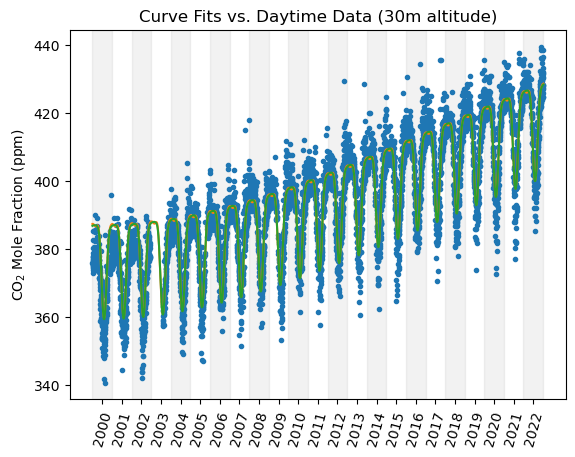

In [31]:
t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in lef_day[30].index])/86400./365.
plt.plot(t,lef_day[30]['co2'],'.')
plt.plot(t,thoning(t,*pt[30]))
plt.plot(t,skewsine(t*365,*ps[30]))
plt.title('Curve Fits vs. Daytime Data (30m altitude)')
plt.ylabel('CO$_2$ Mole Fraction (ppm)')
for i in range(0,23,2):
    plt.axvspan(i,i+1,0,1,color='grey',alpha=0.1)
plt.xticks(np.arange(0.5,23,1),np.arange(2000,2023),rotation=75);


Text(0.5, 0, 'Hour of Day (LST)')

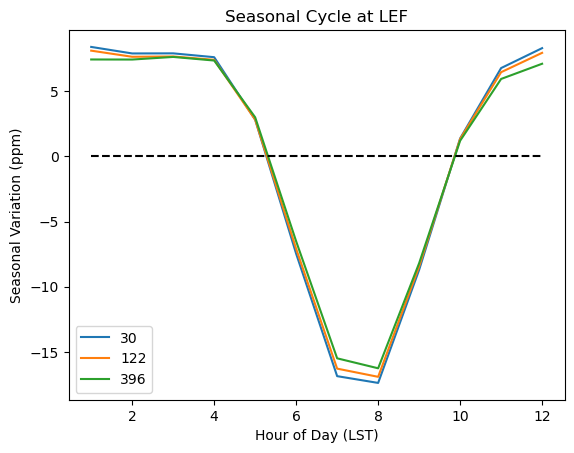

In [32]:
fig,ax=plt.subplots(1,1)
for ky in heights:
    lef_day[ky]['detrend'] = lef_day[ky].thoning-lef_day[ky].trend
    seas = lef_day[ky].groupby(lef_day[ky]['co2'].index.month)['detrend'].mean()
    seas.plot()
ax.legend(heights)
ax.set_title(f'Seasonal Cycle at LEF')
ax.set_ylabel('Seasonal Variation (ppm)')
ax.legend(heights)
#ax.set_ylim([-3,38])
ax.plot([1,12],[0,0],'--k')
ax.set_xlabel('Hour of Day (LST)')

## Examination of Residuals

Text(0, 0.5, 'Residual (ppm)')

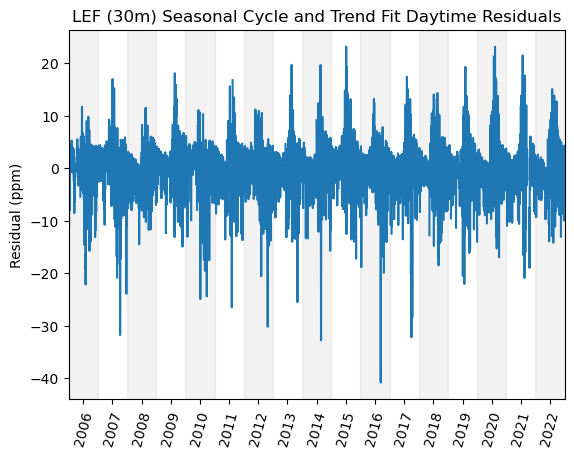

In [33]:
plt.plot(t,thoning(t,*pt[30])-lef_day[30]['co2'])
for i in range(0,23,2):
    plt.axvspan(i,i+1,0,1,color='grey',alpha=0.1)
plt.xticks(np.arange(0.5,23,1),np.arange(2000,2023),rotation=75);
plt.xlim([6,23])
plt.title('LEF (30m) Seasonal Cycle and Trend Fit Daytime Residuals')
plt.ylabel('Residual (ppm)')

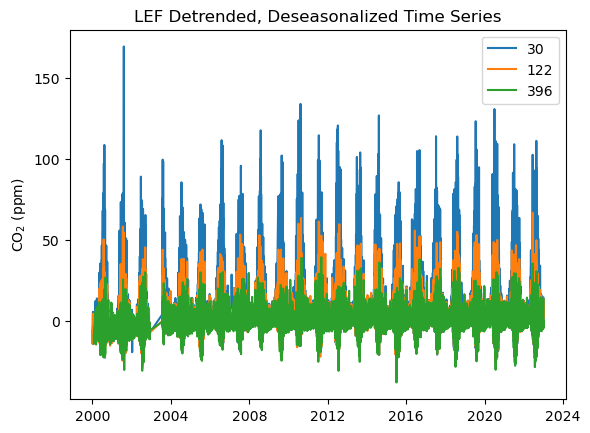

In [34]:
for h in heights:
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in lef_all[h].index])/86400./365
    plt.plot(lef_all[h].co2-thoning(t,*pt[h]))
plt.title('LEF Detrended, Deseasonalized Time Series')
plt.ylabel('CO$_2$ (ppm)')
plt.legend(heights)

## Questions

1. How do you interpret the parameters in the curve fits?
2. How would you interpret the residuals in the daytime data after fitting the curves?
3. What do the large remaining variations in the fits versus the full time series represent?

# Diurnal Cycle Analysis

With detrended and deseasonalized data, we can start to examine other frequencies of variability.  The first place to look is changes over the course of a day from season to season.

## First create a detrended, deseasonalized time series:

In [35]:
for h in heights:
    tmp = lef_all[h]
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in tmp.index])/86400./365.
    lef_all[h]['co2_de'] = lef_all[h].co2-thoning(t,*pt[h])

## Now use groupby to plot diurnal cycle for 4 different months

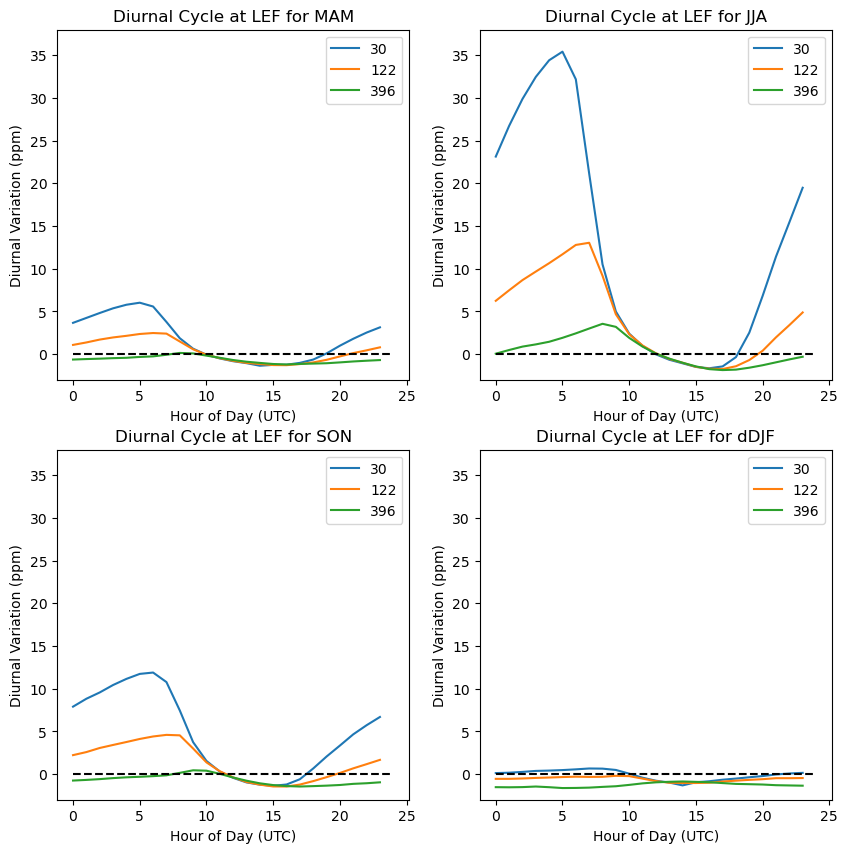

In [36]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
for isn,sn in enumerate(['MAM','JJA','SON','dDJF']):
  ax = axs[isn//2,isn%2]
  for ky in heights:
    inds = np.where((lef_all[ky].index.month > 3*isn+2)*(lef_all[ky].index.month <= 3*isn+5))
    if sn == 'DJF':
      inds = np.where((lef_all[ky].index.month == 12) + (lef_all[ky].index.month < 3))
    ssn_ts = lef_all[ky].iloc[inds]
    ts = ssn_ts.groupby(ssn_ts['co2_de'].index.hour)['co2_de'].mean()
    ax.plot(ts)
  ax.legend(heights)
  ax.set_title(f'Diurnal Cycle at LEF for {sn}')
  ax.set_ylabel('Diurnal Variation (ppm)')
  ax.legend(heights)
  ax.set_ylim([-3,38])
  ax.plot([0,24],[0,0],'--k')
  ax.set_xlabel('Hour of Day (Local)')

## Questions

1. Why are the mole fractions in the 30m data so much larger than the others at nighttime, but overlap with the others in the daytime?
2. What drives the differences in daytime minimum mole fractions between the different seasons?
3. What drives the differences in nighttime maximum mole fractions between the different seasons?
4. What are we assuming about the statistics of the detrended, deseasonalized time series when we make these plots?

# Synoptic Variations

/var/folders/rs/19n1gwk93bx64vmlp3fgdy_h0000gn/T/ipykernel_48238/2533965915.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_ts['synoptic'] = syn_ts['co2_de']
/var/folders/rs/19n1gwk93bx64vmlp3fgdy_h0000gn/T/ipykernel_48238/2533965915.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_ts['synoptic'].iloc[jnds] = syn_ts['co2_de'].iloc[jnds] - ts.iloc[ihr]
/var/folders/rs/19n1gwk93bx64vmlp3fgdy_h0000gn/T/ipykernel_48238/2533965915.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

Text(0.5, 1.0, 'Intermediate Temporal Variations in CO2')

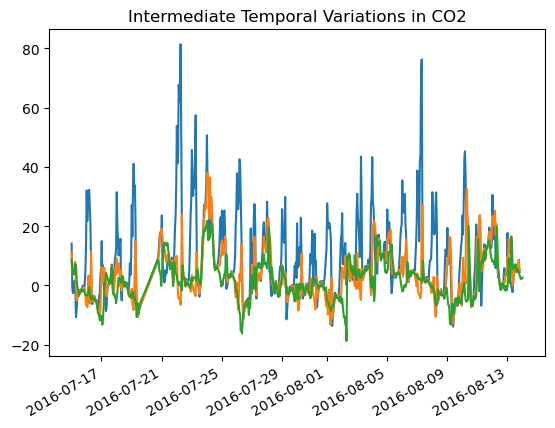

In [39]:
for ky in heights:
  inds = np.where((lef_all[ky].index.month == 6) + (lef_all[ky].index.year == 2016))
  syn_ts = lef_all[ky].iloc[inds]
  ts = syn_ts.groupby(syn_ts['co2_de'].index.hour)['co2_de'].mean()
  syn_ts['synoptic'] = syn_ts['co2_de']
  for ihr in range(24):
      jnds = np.where(syn_ts.index.hour == ihr+1)
      syn_ts['synoptic'].iloc[jnds] = syn_ts['co2_de'].iloc[jnds] - ts.iloc[ihr]
  syn_ts['synoptic'][dt.datetime(2016,7,15):dt.datetime(2016,8,15)].plot()
plt.title('Intermediate Temporal Variations in CO2')

# Extra Credit: Analyze Correlations with Local Eddy Covariance Flux Observations
These data are taken from the Ameriflux measurement site maintained by Ankur Desai's group at the University of Wisconsin and hosted at https://ameriflux.lbl.gov/doi/AmeriFlux/US-PFa/.

Descriptions of variables can be found at https://ameriflux.lbl.gov/data/aboutdata/data-variables/.

### Quick primer on eddy covariance measurements:
Summarized from http://co2.aos.wisc.edu/data/cheas/noselake/OC2008/EddyCovariance_readonly_Li-Cor.pdf

We treat the vertical flux of CO$_2$, $F_c$, via the equation

$F_c = \overline{\rho_a wq}$,

where $w$ is the vertical wind velocity, $q=\frac{\rho_{CO2}}{\rho_a}$ is the mixing ratio of CO$_2$ and $\rho_a$ is density of dry air. Using Reynolds averaging and assuming density fluctuations have mean 0, we arrive at

$F_c \approx \overline{\rho_a} \overline{w'q'} = \overline{w'\rho_{CO2}'}$

The prime indicates instantaneous fluctuations about the mean and the overbar denotes a time average. Calculating these quantities requires a sonic anemometer (which gives the 3D wind field), a CO$_2$ sensor with sufficiently accurate sample-to-sample differences (as opposed to absolute values), and a measurement of pressure and moisture to estimate the dry air mass. 

Important assumptions:
- Density fluctuations are negligible
- Terrain is uniform and flat
- Vertical motions are due to turbulent eddies
- Measurements occur inside the boundary layer

Generally, the surface influence region on a given EC tower measurement is believed to be a roughly 100 to 1 fetch to sensor height ratio.  So a sensor 10$m$ above the ground will be influenced by 100$m^2$ area if the fetch is 1$\frac{m}{s}$.  This breaks down when there is strong convection or the surface roughness is too small or the atmosphere is stable. 

In [50]:
ec = pd.read_csv(FLUX_FOLDER+'/AMF_US-PFa_BASE-BADM_28-5/AMF_US-PFa_BASE_HR_28-5.csv',skiprows=2)

In [51]:
ec.keys()

Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'CO2_1_1_1', 'CO2_1_2_1',
       'CO2_1_3_1', 'H2O_1_1_1', 'H2O_1_2_1', 'H2O_1_3_1', 'H2O_PI_F_1_3_1',
       'CH4_1_1_1', 'CH4_1_2_1', 'CH4_1_3_1', 'FC_1_1_1', 'FC_1_2_1',
       'FC_1_3_1', 'FCH4_1_1_1', 'SC_1_1_1', 'SC_1_2_1', 'SC_1_3_1',
       'SCH4_1_1_1', 'H', 'H_1_1_1', 'H_1_2_1', 'H_1_3_1', 'LE', 'LE_1_1_1',
       'LE_1_2_1', 'LE_1_3_1', 'SH_1_1_1', 'SH_1_2_1', 'SH_1_3_1', 'SLE_1_1_1',
       'SLE_1_2_1', 'SLE_1_3_1', 'WD_1_1_1', 'WD_1_2_1', 'WD_1_3_1',
       'WD_PI_F_1_3_1', 'WS_1_1_1', 'WS_1_2_1', 'WS_1_3_1', 'WS_PI_F_1_3_1',
       'USTAR_1_1_1', 'USTAR_1_2_1', 'USTAR_1_3_1', 'USTAR_PI_F_1_3_1',
       'PA_1_1_1', 'TA_1_1_1', 'TA_1_2_1', 'TA_1_3_1', 'TA_PI_F_1_3_1',
       'VPD_PI_F_1_3_1', 'SWC_1_1_1', 'PPFD_IN_1_1_1', 'P', 'NEE_PI',
       'NEE_PI_F', 'NEE_PI_1_1_1', 'NEE_PI_1_2_1', 'NEE_PI_1_3_1', 'RECO_PI_F',
       'GPP_PI_F', 'RH_1_3_1', 'SWC_2_1_1', 'SWC_2_2_1', 'SWC_2_3_1',
       'SWC_2_4_1', 'SWC_2_5_1', 'SWC_2_6_1', 'S

## First create a datetime index so we can do time series analysis

In [42]:
ts = ec['TIMESTAMP_START'].values
ts_str = [str(t) for t in ts]
YYYY = [int(t[:4]) for t in ts_str]
MM = [int(t[4:6]) for t in ts_str]
DD = [int(t[6:8]) for t in ts_str]
hh = [int(t[8:10]) for t in ts_str]
mm = [int(t[10:12]) for t in ts_str]
dts = np.array([dt.datetime(YYYY[i],MM[i],DD[i],hh[i],mm[i],0) + dt.timedelta(seconds=7*3600) for i in range(len(ts_str))])
ec.index = dts

## Filter out bad data

In [44]:
ec.replace(-9999,np.nan,inplace=True)

## U$^*$ Filtering
We need to exclude data where the winds are not sufficiently turbulent to satisfy the eddy covariance flux theory:
https://www.bgc-jena.mpg.de/5624872/Ustar-filtering

u$^*$ is the friction velocity.  It is known that when u$^*$ is low, EC techniques underestimate net flux.  A solution is to exclude data below a threshold u$^*$ value where the data has a strong linear dependency.  In general this threshold is seasonally dependent and site-specific.

(0.0, 10.0)

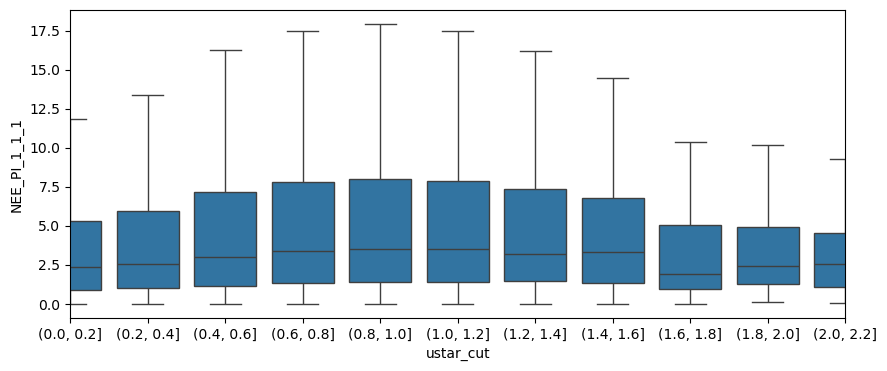

In [98]:
ec['ustar_cut'] = pd.cut(ec['USTAR_1_1_1'],np.arange(0,5,0.2))
plt.figure(figsize=(10,4))
sns.boxplot(x=ec['ustar_cut'],y=np.abs(ec['NEE_PI_1_1_1']),showfliers=False,)
plt.xlim([0,10])

Here we see that in aggregate, there isn't a linear dependence, though a more careful analysis by season might reveal a different picture.  For our purposes, we will proceed without further exploration, as we are using a product that has been pre-analyzed by the site PI and gap-filled.

### Net Ecosystem Exchange (NEE) with PI corrections (_PI) and gap filling (_F)

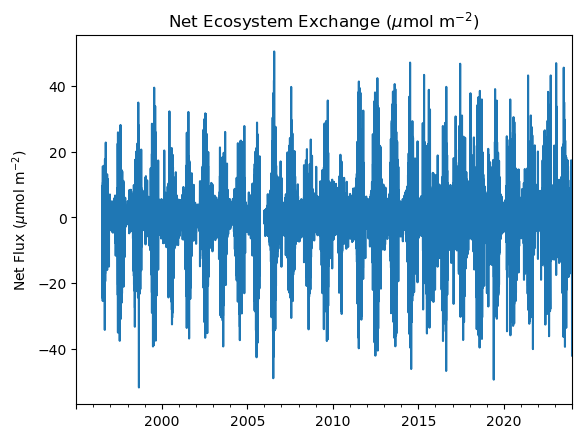

In [99]:
ec['NEE_PI_F'].plot(title='Net Ecosystem Exchange ($\mu$mol m$^{-2}$)',ylabel='Net Flux ($\mu$mol m$^{-2}$)');

### Daytime vs. Nighttime Behavior

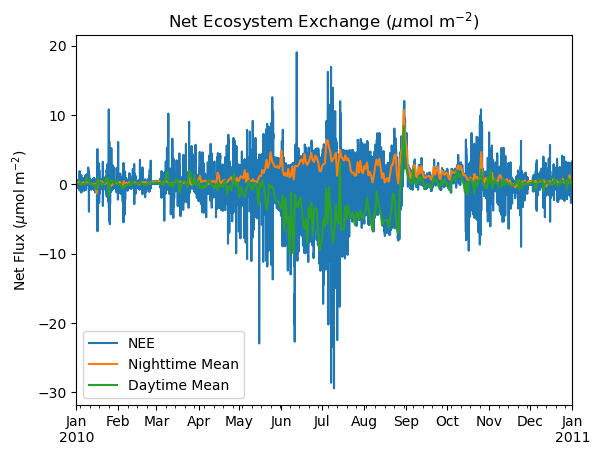

In [100]:
nee = ec.NEE_PI_F
gpp = ec.GPP_PI_F
reco = ec.RECO_PI_F
ec_day = nee.between_time('12:00','0:00').groupby(pd.Grouper(freq='D')).mean()
ec_night = nee.between_time('0:00','12:00').groupby(pd.Grouper(freq='D')).mean()
ec.NEE_PI_F[dt.datetime(2010,1,1):dt.datetime(2011,1,1)].plot(title='Net Ecosystem Exchange ($\mu$mol m$^{-2}$)',ylabel='Net Flux ($\mu$mol m$^{-2}$)');
ec_night[dt.datetime(2010,1,1):dt.datetime(2011,1,1)].plot()
ec_day[dt.datetime(2010,1,1):dt.datetime(2011,1,1)].plot()
plt.legend(['NEE','Nighttime Mean','Daytime Mean'])

### PIs separate the NEE into Gross Ecosystem Exchange (GEE) and Ecosystem Respiration (RECO) - typically temperature predicts RECO and GEE is taken as the residual flux.

Text(0, 0.5, 'Net Flux ($\\mu$mol m$^{-2}$)')

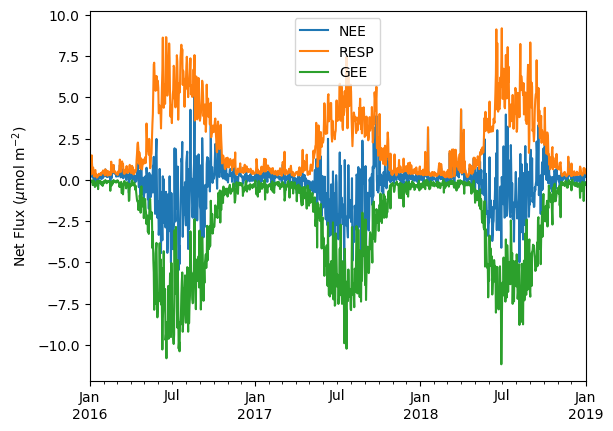

In [45]:
ec.NEE_PI_F.groupby(pd.Grouper(freq='D')).mean()[dt.datetime(2016,1,1):dt.datetime(2019,1,1)].plot()
ec.RECO_PI_F.groupby(pd.Grouper(freq='D')).mean()[dt.datetime(2016,1,1):dt.datetime(2019,1,1)].plot()
(-1*ec.GPP_PI_F).groupby(pd.Grouper(freq='D')).mean()[dt.datetime(2016,1,1):dt.datetime(2019,1,1)].plot()
plt.legend(['NEE','RESP','GEE'])
plt.ylabel('Net Flux ($\mu$mol m$^{-2}$)')



## Now plot the diurnal net flux versus the de-trended, de-seasonalized mole fraction.

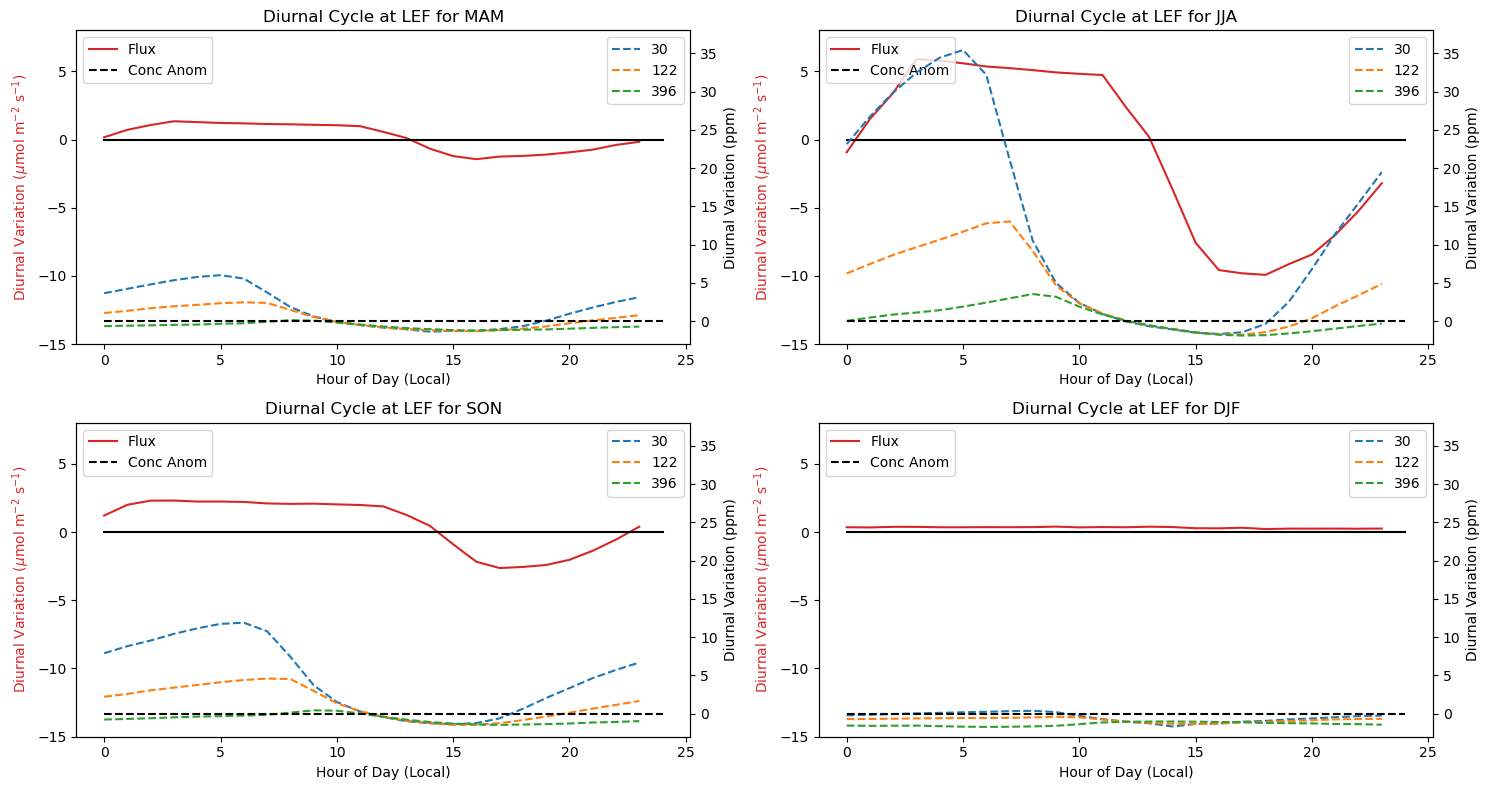

In [46]:
pt,lb = [],[]
pt.append(plt.plot([0,0],[1,1],color='tab:red'))
pt.append(plt.plot([0,0],[1,1],'--',color='k'))
plt.close()

fig,axs=plt.subplots(2,2,figsize=(15,8))
for isn,sn in enumerate(['MAM','JJA','SON','DJF']):
  ax = axs[isn//2,isn%2]
  ky = f'NEE_PI_F'
  inds = np.where((ec.index.month > 3*isn+2)*(ec.index.month <= 3*isn+5))
  if sn == 'DJF':
    inds = np.where((ec.index.month == 12) + (ec.index.month < 3))
  ssn_ts = ec.iloc[inds]
  ts = ssn_ts.groupby(ssn_ts.index.hour)[ky].mean()
  ax.plot(ts,color='tab:red')

  ax2 = ax.twinx()
  for ky in heights:
    inds = np.where((lef_all[ky].index.month > 3*isn+2)*(lef_all[ky].index.month <= 3*isn+5))
    if sn == 'DJF':
      inds = np.where((lef_all[ky].index.month == 12) + (lef_all[ky].index.month < 3))
    ssn_ts = lef_all[ky].iloc[inds]
    ts = ssn_ts.groupby(ssn_ts['co2_de'].index.hour)['co2_de'].mean()
    ax2.plot(ts,'--')
  ax.set_title(f'Diurnal Cycle at LEF for {sn}')
  ax.set_ylabel('Diurnal Variation ($\mu$mol m$^{-2}$ s$^{-1}$)',color='tab:red')
  ax2.set_ylim([-3,38])
  ax2.plot([0,24],[0,0],'--k')
  ax.legend([pt[0][0],pt[1][0]],['Flux','Conc Anom'],loc='upper left')

  ax.set_title(f'Diurnal Cycle at LEF for {sn}')
  ax2.set_ylabel('Diurnal Variation (ppm)')
  ax2.legend(heights)
  ax.set_ylim([-15,8])
  ax.plot([0,24],[0,0],'k')
  ax.set_xlabel('Hour of Day (Local)')
plt.tight_layout()

## Questions

1. What drives the differences in flux from season to season?
2. What drives the daily cycle of flux?
3. Are the flux and mole fraction time series correlated? Is there an obvious lag?  What would be causing that lag?